In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from PIL import Image
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from skimage.feature import hog
from skimage.color import rgb2gray

#Obtaining Image Feature and Label

Pillow library - Easily manipulate images such as opening, editing and saving them in various formats.

In [5]:
folder = '/content/drive/MyDrive/Colab Notebooks/Face Detection/a1_TrainingPhotos'
images = []
i = 0

X = [] #Stores feature data
Y = [] #Stores labels for the images

# Process each image in the folder
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    img = Image.open(img_path).resize([32, 64])  # Resize image to a fixed size
    img = np.array(img)
    img = rgb2gray(img)  # Convert to grayscale

    # Extract HOG features
    fd, _ = hog(img, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True, channel_axis=None)
    X.append(fd)

    # Assign label based on filename
    if re.match("Amir.*", filename):
        Y.append(0)
    elif re.match("Jaya.*", filename):
        Y.append(1)
    elif re.match("Hir.*", filename):
        Y.append(2)
    elif re.match("Anupam.*", filename):
        Y.append(3)
    else:
        Y.append(4)  # Default label for unmatched cases

In [6]:
fd.shape

(3780,)

In [7]:
target_names = ['AmirKhan', 'JayaBadhuri', 'HritikRoshan', 'AnupamKher']
#Images are converted into numerical representations

#Split Data into Training and Test

In [8]:
# 80% - Training
# 20% - Test
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#Reducing Dimensions with Principal Component Analysis (PCA)

In [9]:
# Apply PCA for dimensionality reduction
n_components = 25
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [11]:
#Saving PCA coefficients for future use (prediction)
import pickle as pk
pk.dump(pca, open('pca.pkl', 'wb'))

#Train Support Vector Machine(SVM) classifier

In [12]:
print("Fitting the classifier to the training set")
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced',probability=True), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.1, probability=True)


In [13]:
#Save best SVM classifier weights for use at prediction
import joblib
joblib.dump(clf.best_estimator_, 'c2_FR_svm_classifier.pkl', compress = 1)

['c2_FR_svm_classifier.pkl']

#Model performance on test  set


In [17]:
y_pred = clf.predict(X_test_pca)
y_pred

array([1, 0, 2, 1, 1, 0, 0, 0, 0, 1, 2, 1, 0, 2, 0, 0, 2, 0, 0, 1, 0, 1,
       1, 1, 0, 2, 0, 0, 0, 1, 0, 1, 3, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 0,
       0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 1, 3, 1, 0, 0,
       2, 2, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 2,
       0, 0, 3, 2, 0, 3, 0, 1, 0, 2, 0, 0, 1, 1, 2, 2, 0, 1, 0])

In [18]:
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

    AmirKhan       0.79      0.90      0.84        49
 JayaBadhuri       0.93      0.81      0.87        32
HritikRoshan       0.63      0.75      0.69        16
  AnupamKher       1.00      0.40      0.57        10

    accuracy                           0.80       107
   macro avg       0.84      0.72      0.74       107
weighted avg       0.83      0.80      0.80       107



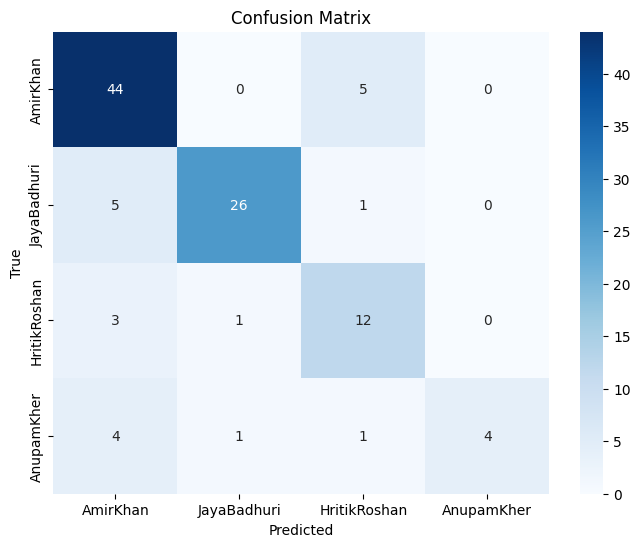

In [19]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_test and y_pred are already defined from the previous code
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

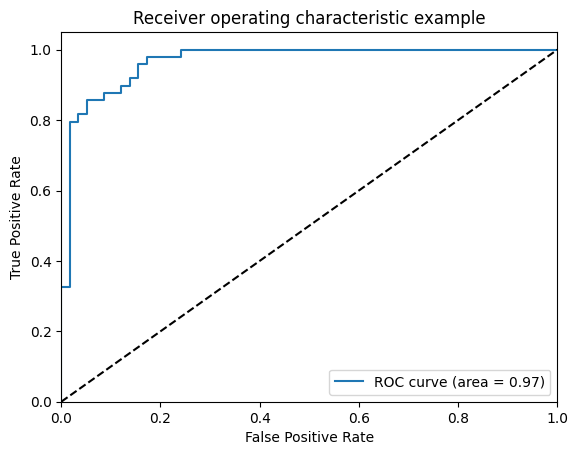

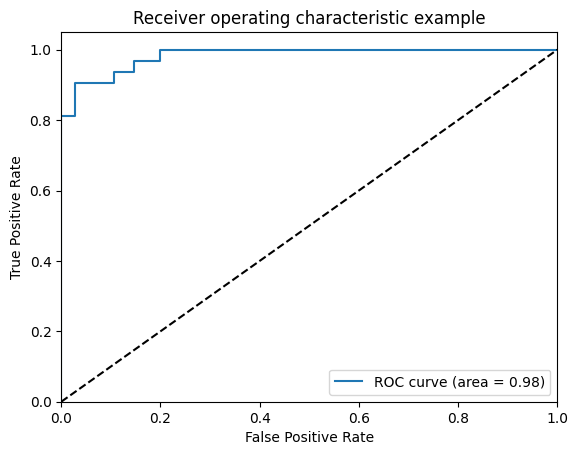

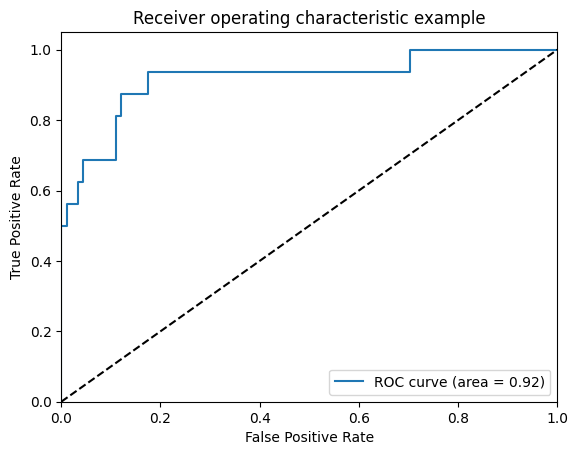

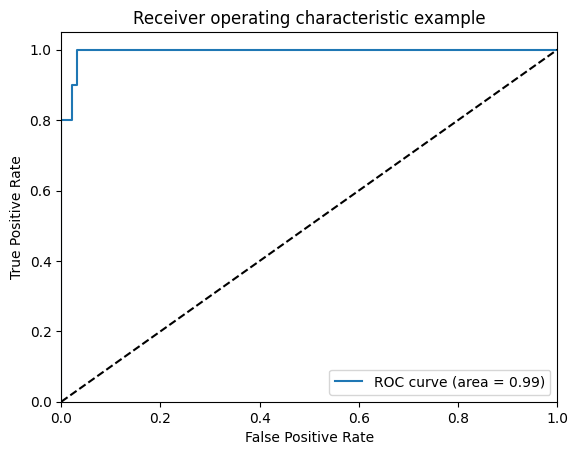

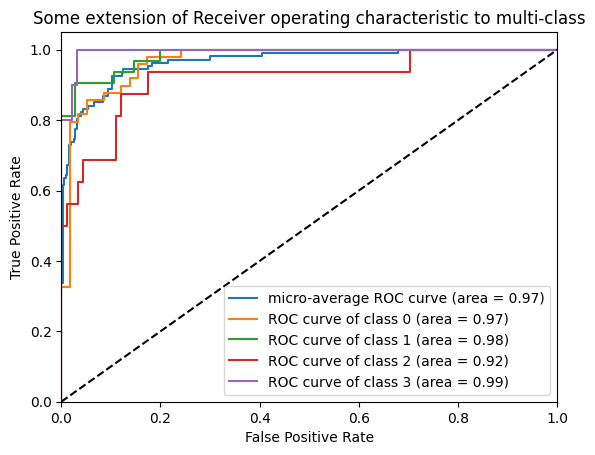

In [20]:
# AUC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], clf.predict_proba(X_test_pca)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), clf.predict_proba(X_test_pca).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()